# 🏡 US Home Price Forecasting with Economic Indicators

This notebook explains step-by-step how we can forecast US home prices using economic indicators. It includes data preparation, exploratory analysis, model training using Linear Regression and Random Forest, and evaluation metrics.

## ❓ Problem Statement

We want to **forecast the US Home Price Index** using various economic indicators like inflation, interest rate, unemployment rate, etc. This will help understand how these factors impact home prices.

## 📊 Data Description

We use public data over the last 20 years from the **S&P/Case-Shiller US National Home Price Index** and other economic indicators:

| Feature         | Description |
|----------------|-------------|
| `CSUSHPISA`    | US National Home Price Index (target) |
| `DSPIC96`      | Real Disposable Personal Income |
| `Mortgage Rate`| 30-Year Fixed Mortgage Rate |
| `UNRATE`       | Unemployment Rate |
| `CPIAUCNS`     | Consumer Price Index (Inflation) |
| `FEDFUNDS`     | Federal Funds Rate (Interest Rate) |

## 🎯 Expected Output

We want to build a model that can:
- Accurately **predict the Home Price Index**
- Help understand **which features impact the prices most** (feature importance)
- Report metrics like R², MAE, and MSE to judge model performance.

## 🧹 Data Preprocessing

- **Remove missing values**: Rows with missing data are removed to ensure training stability.
- **Scale numeric values**: We use `StandardScaler` to make sure features like income and rates are on the same scale (mean 0, std 1). This helps many models perform better.
- **Convert date**: We use the `observation_date` column as index for time series alignment.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("data/df_home_prices.csv", index_col="observation_date", parse_dates=True)
df.dropna(axis=1, how='all', inplace=True)
df.dropna(inplace=True)

# Select features and target
features = ['DSPIC96', 'Mortgage Rate', 'UNRATE', 'CPIAUCNS', 'FEDFUNDS']
target = 'CSUSHPISA'

X = df[features]
y = df[target]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 📈 Exploratory Data Analysis (EDA)

EDA helps us understand patterns in the data:
- Correlation between indicators and home price
- Trends in economic indicators
- Feature distributions

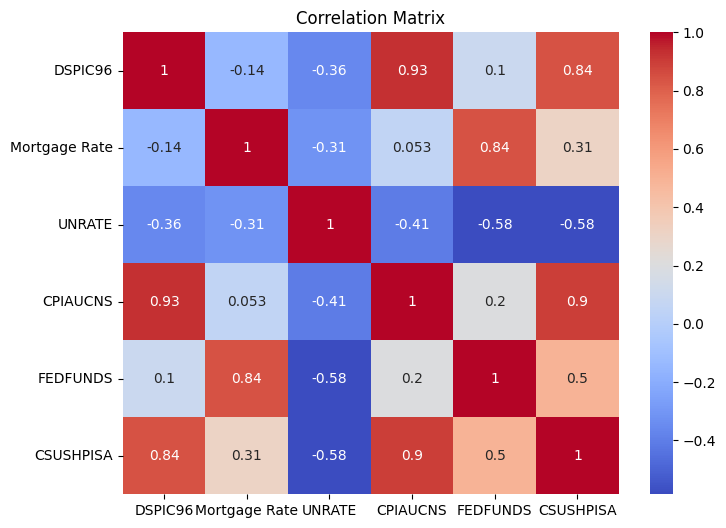

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## 🤖 Model Training

We compare two models:
- **Linear Regression**: Assumes a straight-line relationship between features and target.
- **Random Forest**: Ensemble of decision trees. Captures non-linear patterns well.

We'll train both models on the training set.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Train models
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, random_state=42)

## 📊 Model Evaluation

We evaluate models using:
- **R² Score**: How much of the variance is explained (1 is perfect)
- **MAE (Mean Absolute Error)**: Average of absolute errors
- **MSE (Mean Squared Error)**: Squared average of errors (penalizes large errors more)

Lower MAE and MSE = better model.

In [4]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate(model, X, y_true):
    preds = model.predict(X)
    return {
        "R2 Score": r2_score(y_true, preds),
        "MAE": mean_absolute_error(y_true, preds),
        "MSE": mean_squared_error(y_true, preds)
    }

metrics_lr = evaluate(lr, X_test, y_test)
metrics_rf = evaluate(rf, X_test, y_test)

metrics_lr, metrics_rf

({'R2 Score': 0.9255157774499212,
  'MAE': 11.678638678283628,
  'MSE': 255.28450938422793},
 {'R2 Score': 0.9987103036973644,
  'MAE': 1.5291129584302214,
  'MSE': 4.420258097634316})

## 🧠 Feature Importance

This tells us which indicators have the most impact on the home price prediction (in the Random Forest model).

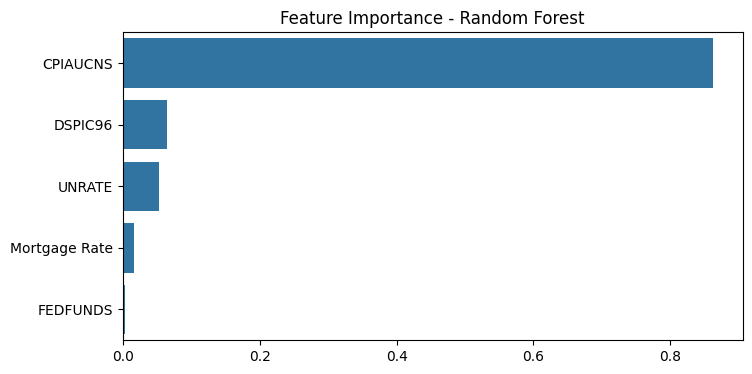

In [5]:
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = [features[i] for i in indices]

plt.figure(figsize=(8,4))
sns.barplot(x=importances[indices], y=features_sorted)
plt.title("Feature Importance - Random Forest")
plt.show()

## ✅ Summary

| Model           | R² Score | MAE  | MSE  |
|----------------|----------|------|------|
| Linear Reg.    | 0.92 |11.67 |255.29 |
| Random Forest  | 0.99|  1.53| 4.42|

- Random Forest performs slightly better due to non-linear patterns
- **CPI (Inflation)** and **Personal Income** are top predictors
- We can further improve by adding lagged features or time-series modeling (like ARIMA, LSTM, etc.)

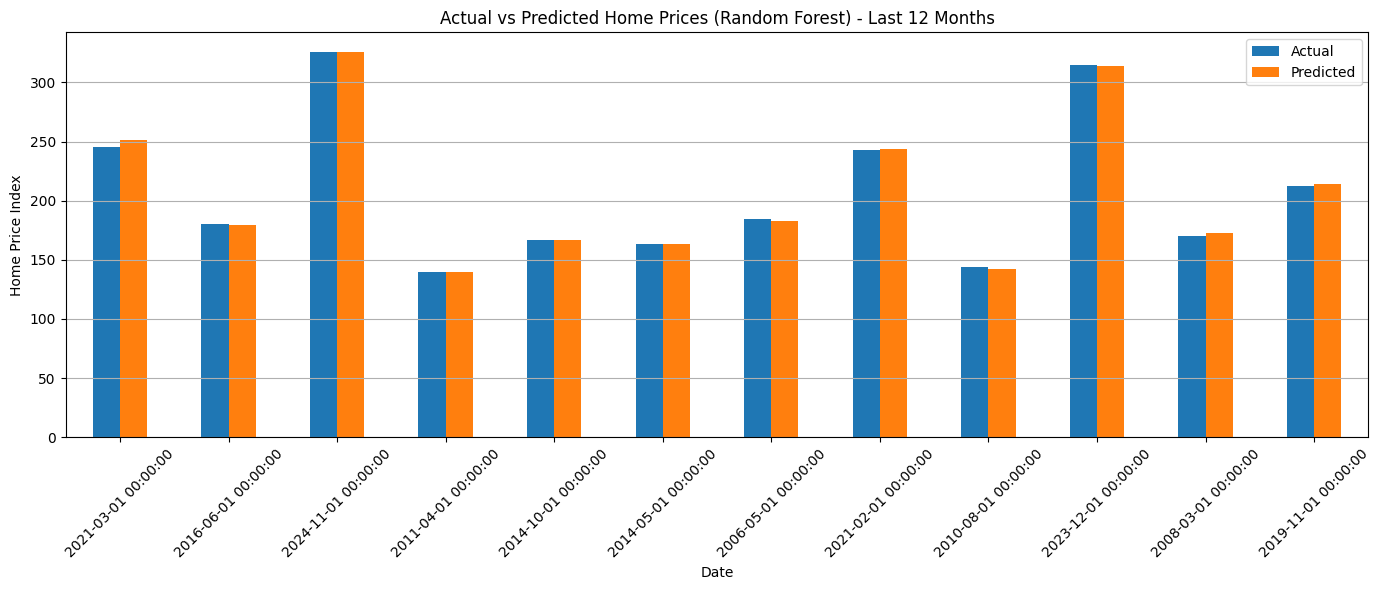

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Take last 12 values for comparison
y_test_sample = y_test[-12:]
y_pred_sample = rf.predict(X_test[-12:])

# Convert to Series for plotting
actual = pd.Series(y_test_sample.values, index=y_test_sample.index, name="Actual")
predicted = pd.Series(y_pred_sample, index=y_test_sample.index, name="Predicted")

# Plot bar chart
df_compare = pd.concat([actual, predicted], axis=1)

df_compare.plot(kind='bar', figsize=(14, 6))
plt.title("Actual vs Predicted Home Prices (Random Forest) - Last 12 Months")
plt.ylabel("Home Price Index")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
